In [4]:
import matplotlib.pyplot as plt

from os import chdir
chdir('../DB')
from setting import METRIC_TYPE
from vector_db import MilvusCollection
from relational_db import SQLiteDB
from towhee import AutoConfig, AutoPipes
from loguru import logger
from json import load
from numpy import array, argpartition


data_path = '../data/Query_BART_Keywords_artificially_prob.json'
collection_name = 'BERT_keywords'
partition = 'en'

collection = MilvusCollection(collection_name)
sqlite_db = SQLiteDB('sqlite/context')

config = AutoConfig.load_config('sentence_embedding')
config.model = 'average_word_embeddings_glove.6B.300d'
sentence_embedding = AutoPipes.pipeline('sentence_embedding', config=config)

In [5]:
search_params = {
    "metric_type": METRIC_TYPE,
    "params": {
        # search for vectors with a distance greater than 0.8
        "radius": 0.8
    }
}

logger.debug("Loading data in '" + data_path + "'")

with open(data_path, 'r') as file:
    queries = load(file)[:10000]

logger.debug("Data in '" + data_path + "' loaded")
logger.debug("Generating embeddings")

keywords = []
list_weights = [None] * len(queries)

for i, query in enumerate(queries):
    kws = query['keywords']
    if 'prob' in query:
        prob = query['prob']
        # print(i, ',', prob)
        prob = [.9 if p == '' else float(p) for p in prob] ## Remove later
        s = sum(prob)
        list_weights[i] = [p / s for p in prob]
    else:
        length = len(kws)
        list_weights[i] = [1. / length] * length
    keywords += kws

embeddings = [embedding.get()[0] for embedding in sentence_embedding.batch(keywords)]

logger.debug("Embeddings generated")
logger.debug("Searching in partition <" + partition + "> from collection <" + collection_name + '>')

length = len(embeddings)
results = [None] * length

i = 0

# 16384 is milvu's maximum search batch size
while i + 16384 < length:
    search_results = collection.search(embeddings[i:i + 16384], "embedding", search_params, 5, partition_names=[partition], output_fields=["context_ids"])
    
    for search_result in search_results:
        results[i] = search_result
        i += 1

search_results = collection.search(embeddings[i:], "embedding", search_params, 5, partition_names=[partition], output_fields=["context_ids"])
    
for search_result in search_results:
    results[i] = search_result
    i += 1

logger.debug("Searching completed")

recalls = []
recall = 0.
left_index = 0

for i, weights in enumerate(list_weights):
    score = {}
    for j, weight in enumerate(weights):
        result = results[left_index + j]
        for hit in result:
            distance = hit.distance
            for context_id in hit.context_ids:
                if context_id in score:
                    score[context_id] += weight * distance
                else:
                    score[context_id] = weight * distance
    
    length = len(score)
    
    if length < 6:
        keys = list(score.keys())
    else:
        values = array(list(score.values()))
        args = argpartition(values, -5)[-5:]
        keys = array(list(score.keys()))[args]
    
    context_id = queries[i]['context_id']
    # print(f"docs retrieved for query {i}: {keys} (expected: {context_id})")
    
    if context_id in keys:
        recall = (i * recall + 1) / (i + 1)
    else:
        recall *= i / (i + 1)
    
    # print("recall: ", recall)
    # print('\n')
    recalls.append(recall)
    left_index += len(weights)

print('recall = ', recall)

2024-02-14 01:00:19.384 | DEBUG    | __main__:<module>:9 - Loading data in '../data/Query_BART_Keywords_artificially_prob.json'
2024-02-14 01:00:19.415 | DEBUG    | __main__:<module>:14 - Data in '../data/Query_BART_Keywords_artificially_prob.json' loaded
2024-02-14 01:00:19.416 | DEBUG    | __main__:<module>:15 - Generating embeddings
2024-02-14 01:00:47.382 | DEBUG    | __main__:<module>:35 - Embeddings generated
2024-02-14 01:00:47.383 | DEBUG    | __main__:<module>:36 - Searching in partition <en> from collection <BERT_keywords>
2024-02-14 01:01:00.766 | DEBUG    | __main__:<module>:57 - Searching completed


recall =  0.32749999999999907


Text(0, 0.5, 'recall')

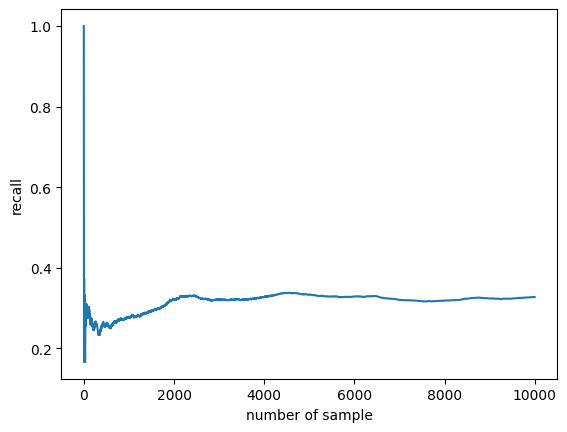

In [6]:
plt.plot(recalls)
plt.xlabel('number of sample')
plt.ylabel('recall')